# Basic doodle classification using Hybrid-QCNN

## Overview
This Jupyter notebook implements a Hybrid Quantum Convolutional Neural Network (Hybrid-QCNN) for doodle classification on a reduced portion of the Google's Quick Draw dataset.


### Structure
The structure of this notebook is as follows:
1. [Introduction](#1-introduction): A brief overview of the problem, the approach, and the goals.
2. [Data Preprocessing](#2-data-preprocessing): The steps taken to prepare the data for modeling, including any necessary data cleaning, normalization, or feature engineering.
3. [Hybrid Modeling](#3-hybrid-modeling): The implementation of the Hybrid-QCNN architecture, including the use of quantum-inspired techniques.
4. [Training](#4-training): The training process for the model, including the choice of optimizer, loss function, and hyperparameters.
5. [Evaluation](#5-evaluation): The evaluation of the trained model, including metrics used to assess its performance, and any visualizations or results.

## 1. Introduction
Doodles are a unique form of artistic expression that have gained popularity in recent years. The Google Quick, Draw! dataset provides a vast repository of doodles that can be used to train and evaluate machine learning models. In this notebook, we implement a Hybrid Quantum Convolutional Neural Network (Hybrid-QCNN) to classify doodles into their respective categories.

The main challenge in doodle classification is the high variability and complexity of doodle designs. Traditional deep neural networks have been shown to be effective for image classification tasks, but they may not fully capture the quantum-inspired nature of doodle patterns. To address this issue, we incorporate quantum-inspired techniques into our model, leveraging the power of quantum computing to improve the performance and robustness of our classifier.

In this notebook, we will explore the implementation details of our Hybrid-QCNN model, including the data preprocessing steps, the architecture design, and the training process. We will also evaluate the performance of our model.

**References:**

[1] Senokosov et al., [Quantum machine learning for image classification](https://arxiv.org/abs/2304.09224)

First, let's import the required libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from qiskit_algorithms.utils import algorithm_globals
from qiskit import QuantumCircuit
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import cat, no_grad, manual_seed
from torch.nn import NLLLoss, Module, Conv2d, Linear, Flatten, BatchNorm2d
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from rust_sketch import sketches_to_images


SEED = 42

BATCH_SIZE = 1
N_SAMPLES = 100
LEARNING_RATE = 0.001
N_EPOCHS = 50

manual_seed(SEED)
algorithm_globals.random_seed = SEED

## 2. Data preprocessing

In this section, we will prepare our dataset for training and testing by loading and processing the doodle data from the Google Quick, Draw! dataset.

### 2.1 Load Dataset

We load the camera and phone datasets using Pandas' `read_json` function, specifying that the files are in JSON Lines format with a limited number of rows (1,000) for faster processing. We then drop unnecessary columns and convert the sketch data into images using the `sketches_to_images` function.

The `sketches_to_images` function, which is implemented in Rust, is used to convert the sketch data into images. This function takes a batch of sketches as input, along with the old and new sizes, and returns a vector of images.

In [2]:
camera_df = pd.read_json('../data/quickdraw/full_simplified_camera.ndjson', lines=True, nrows=1000)
phone_df = pd.read_json('../data/quickdraw/full_simplified_cell phone.ndjson', lines=True, nrows=1000)
calculator_df = pd.read_json('../data/quickdraw/full_simplified_calculator.ndjson', lines=True, nrows=1000)

# Drop unnecessary columns and process drawings
for df in [camera_df, phone_df, calculator_df]:
    df.drop(["timestamp", "countrycode", "key_id", "recognized"], axis=1, inplace=True)
    df["drawing"] = sketches_to_images(df.drawing.array, 255, 28)

# Concatenate DataFrames
df = pd.concat([camera_df, phone_df, calculator_df])

### 2.2 Split train and test datasets

In this step, we split our dataset into training (80%) and testing (20%) sets using the `train_test_split` function from scikit-learn. The `test_size` parameter is set to 0.2, which means that 20% of the data will be used for testing. We also use a random seed (`random_state=SEED`) to ensure reproducibility.

Additionally, we apply label encoding to the class labels using the `LabelEncoder` from scikit-learn.

In [3]:
# Split data into train and test sets for camera data
X_train, X_test, y_train, y_test = train_test_split(
    df['drawing'], df['word'], test_size=0.2, random_state=SEED)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### 2.3 Load train dataset

In this step, we convert our training data into tensors using PyTorch and create a dataset and data loader for training.

We first convert the `X_train` and `y_train` lists to tensors using `torch.tensor`. We specify the data type as `torch.float32` for the input data and `torch.long` for the class labels, assuming that they are integers. The `-1` in the reshape function is used to automatically determine the batch size. We then create a `TensorDataset` from these tensors and a `DataLoader` to load batches of training data during training. The `batch_size` parameter determines how many samples are loaded at once, and `shuffle=True` ensures that the order of the batches is randomized.

In [4]:
# Train Dataset
# --------------
X_train_tensor = torch.tensor(X_train.tolist(), dtype=torch.float32).reshape(-1, 28, 28)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Let's check the shape of our training dataset:

In [5]:
X_train_tensor.shape

torch.Size([2400, 28, 28])

### 2.4 Load test dataset

We also performed the same process for the test dataset:

In [6]:
# Test Dataset
# --------------
X_test_tensor = torch.tensor(X_test.tolist(), dtype=torch.float32).reshape(-1, 28, 28)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.long)  # Assuming y_test contains class labels as integers

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 3. Hybrid-modeling

This section focuses on defining the quantum parts of our hybrid quantum-classical model. The components included here are the quantum feature map and the quantum ansatz, which are crucial for encoding classical data into quantum states and processing these states respectively.

**Explanation**:
* **Quantum Feature Map**: This function creates a quantum circuit that applies a series of parameterized Rx gates to encode classical data into a quantum state. The parameters (features) correspond to aspects of the input data.
* **Quantum Ansatz**: This function constructs a quantum circuit that processes quantum data using a series of parameterized rotations and entangling operations. The weights are used to adjust the rotations, and the pattern of entangling gates (CNOTs) is designed to spread quantum information across the circuit, which can be crucial for learning complex patterns in data.

In [7]:
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)
    
    for i in range(n):
        circuit.rx(features[i], i)
    
    return circuit
    
def quantum_ansatz(n: int) -> QuantumCircuit:
    # Creamos un circuito cuántico con n qubits.
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)
    
    # Asumiendo que 'weights' es una lista de valores de peso,
    # y la longitud es suficiente para aplicar Rz a cada qubit.
    for i in range(n):
        circuit.rz(weights[i], i)
        
    # Aplicar más rotaciones, que en la imagen parecen ser Ry
    for i in range(n):
        circuit.ry(weights[n+i], i)
        
    for i in range(n):
        circuit.rz(weights[2*n+i], i)
        
    # Aplicar entrelazamiento con puertas CNOT
    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)
    
    return circuit

Let's also define the function that creates the whole parametrized quantum circuit (Feature Map + Ansatz):

In [8]:
# Define and create QNN
def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)
    
    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

Let's check the whole quantum circuit:

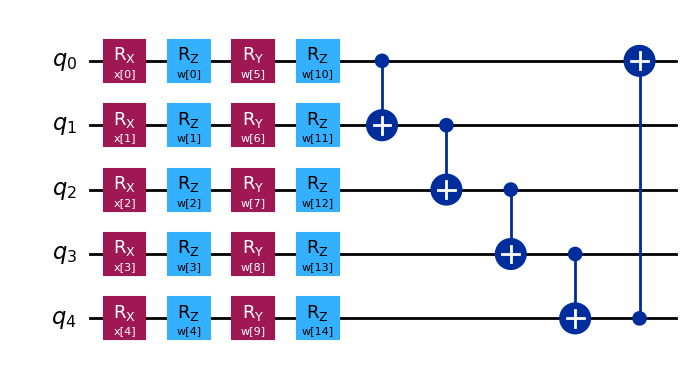

In [9]:
qnn, qc = create_qnn(5)
qc.draw("mpl")

This neural network, defined in the `Net` class, integrates classical convolutional layers with a quantum neural network layer, leveraging the strengths of both classical and quantum computing paradigms. The structure is designed to process image data, commonly used in tasks such as doodle classification.

### Components of the Network

#### Classical Convolutional Layers
- **First Convolutional Layer (`conv1`)**:
  - **Channels**: Processes single-channel input (e.g., grayscale images) and outputs 16 feature maps.
  - **Kernel Size**: Uses a 5x5 kernel to capture spatial hierarchies.
  - **Padding**: Applies padding of 2 to preserve spatial dimensions after convolution.
  - **Batch Normalization (`bn1`)**: Normalizes the output of `conv1` to improve training stability and speed.

- **Second Convolutional Layer (`conv2`)**:
  - Increases the depth to 32 feature maps while maintaining the spatial dimensions, similar to `conv1`.

#### Pooling Layers
- **Max Pooling**: Applied after each convolutional layer with a kernel size of 2x2, reducing the spatial dimensions by half. This operation helps in reducing the computational complexity and overfitting by abstracting the higher-level features.

#### Hybrid Dense Layers
- **Flattening**: Converts the multidimensional feature maps into a 1D feature vector necessary for the dense layer.
- **First Fully Connected Layer (`fc1`)**:
  - Transforms the flattened output into an intermediate space of 5 features.

#### Quantum Layer
- **Quantum Neural Network (`qnn`)**: Integrated via `TorchConnector`, this layer allows for quantum computations within the network flow, potentially capturing complex patterns that are difficult for classical layers.

#### Output Processing
- **Second Fully Connected Layer (`fc2`)**: Processes the quantum layer's output to produce a single output feature.
- **Concatenation**: The final layer output is concatenated with its complement (`1 - x`) to ensure the output sums to one, often used in binary classification tasks.

### Forward Pass
- The input passes sequentially through `conv1`, `bn1`, and a ReLU activation, followed by max pooling, repeating this process for `conv2`.
- After processing through both convolutional layers and pooling, the data is flattened and passed through `fc1` with a ReLU activation.
- The quantum layer receives the processed classical data, applies quantum operations, and passes the result to `fc2`.
- The final output is adjusted by concatenating it with its complement, preparing it for output tasks such as classification.

### Discussion
This architecture effectively combines classical deep learning methods for robust feature extraction with the exploratory capabilities of quantum computing. The design aims to experiment with how quantum layers can enhance classical prediction models, particularly in complex image classification scenarios.

In [10]:
# Define torch NN module
class Net(Module):
    def __init__(self, qnn, num_classes=2):
        super().__init__()
        # Classical convolutional layer
        self.conv1 = Conv2d(
            in_channels=1, 
            out_channels=16, 
            kernel_size=5,
            padding=2
        )
        self.bn1 = BatchNorm2d(16)
        
        self.conv2 = Conv2d(
            in_channels=16, 
            out_channels=32, 
            kernel_size=5,
            padding=2
        )
        
        # Hybrid dense layers
        self.flatten = Flatten()
        self.fc1 = Linear(in_features=32 * 7 * 7, out_features=5)
        
        # Quantum layer
        self.qnn = TorchConnector(qnn)
        self.fc2 = Linear(1, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.conv2(x)) # Batch normalization ?? ReLU ??
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.fc1(self.flatten(x))) # Batch normalization ??
        
        x = self.qnn(x)
        x = self.fc2(x) # ReLU ?? Batch normalization ??
        
        # Apply softmax for multi-class classification
        x = F.softmax(x, dim=1)
        return x

model = Net(qnn, num_classes=3)

## 4. Training

This section details the training process for our hybrid quantum-classical neural network. The network utilizes both classical and quantum layers to optimize performance on the classification task.

We use the Adam optimizer, known for its efficiency in handling sparse gradients and adaptive learning rate capabilities. The learning rate is set through the `LEARNING_RATE` variable, allowing control over how much the model weights are adjusted during training.
The Negative Log Likelihood Loss (`NLLLoss`) is used as the loss function. It is suitable for classification problems with `C` classes when using a log-softmax layer as the final output, which must be the case here.

Training occurs over `N_EPOCHS`, allowing the model to iteratively learn from the entire dataset. The training data is processed in batches using `train_loader`. This helps in managing memory usage and allows the optimizer to update model parameters iteratively, refining the learning after each batch. Each batch of data is fed forward through the model (`model(data.unsqueeze(0))`) to compute the predicted outputs. The `unsqueeze(0)` might be used to adjust the dimensions of the input data to match the model's expected input shape (if necessary). The loss between the predicted outputs and the actual targets (`target`) is calculated. This value represents how well the model's predictions match the actual labels. The backward pass computes the gradient of the loss function with respect to the model parameters (`loss.backward()`). This step is crucial for learning as it indicates how each parameter should be adjusted to minimize the loss. The optimizer updates the model parameters based on the gradients calculated during the backward pass (`optimizer.step()`). The loss for each batch is recorded, and the average loss per epoch is calculated and stored in `loss_list`. This average loss is printed after each epoch to monitor the training progress.

After each epoch, the training progress is outputted as a percentage of completion along with the average loss. This feedback is valuable for monitoring the training process and determining when the model has sufficiently learned or if adjustments need to be made to training parameters like the learning rate or the number of epochs.

In [ ]:
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# Define optimizer and loss functions
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_func = CrossEntropyLoss()

# Start training
epochs = N_EPOCHS
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

model.train()

for epoch in range(epochs):
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), desc="Training Batches", leave=False):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        output = model(data.unsqueeze(0))
        
        # Calculate loss
        loss = loss_func(output, target)
        loss.backward()
        
        # Optimize weights
        optimizer.step()
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    train_loss_list.append(total_loss / len(train_loader))
    train_acc_list.append(100 * correct / total)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.unsqueeze(0))
            loss = loss_func(output, target)
            val_loss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()
    
    val_loss_list.append(val_loss / len(test_loader))
    val_acc_list.append(100 * val_correct / val_total)
    
    model.train()
    
    print(f"Epoch [{epoch + 1}/{epochs}] "
          f"Train Loss: {train_loss_list[-1]:.4f} "
          f"Train Acc: {train_acc_list[-1]:.2f}% "
          f"Val Loss: {val_loss_list[-1]:.4f} "
          f"Val Acc: {val_acc_list[-1]:.2f}%")

Epoch [1/50] Train Loss: 1.1006 Train Acc: 33.92% Val Loss: 1.1001 Val Acc: 31.00%


Epoch [2/50] Train Loss: 1.0989 Train Acc: 33.92% Val Loss: 1.0996 Val Acc: 31.00%


Training Batches: 252it [00:20, 11.64it/s]

Let's see how the model performed over training iterations.

In [ ]:
# Plotting the metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()

Finally, we saved our trained model for future usage.

In [ ]:
torch.save(model.state_dict(), "model.pt")

## 5. Evaluation

After training, the next crucial step is to evaluate the model's performance using the test dataset. The evaluation process is crucial to assess the generalization ability of the model on unseen data.

The trained model weights are loaded from "model.pt", ensuring that the model used for evaluation has the trained parameters.

In [ ]:
qnn1, _ = create_qnn(5)
model1 = Net(qnn1)
model1.load_state_dict(torch.load("model.pt"))

Setting the model to eval() mode is crucial as it disables dropout and batch normalization during the inference, ensuring consistent performance across different test inputs. 

We perform inference under the no_grad() context to prevent PyTorch from calculating gradients, which are unnecessary during evaluation and only consume extra memory and computing power. For each batch, the model's predictions are compared against the actual labels to compute the number of correct predictions and the loss. These metrics provide insight into the model's effectiveness. Finally, the average loss and accuracy over all test data are computed and printed, providing a straightforward assessment of the model's performance.

In [ ]:
model1.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model1(data.unsqueeze(1))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output.squeeze(-1), target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / BATCH_SIZE * 100
        )
    )

This block of code visualizes the predictions for a subset of the test dataset. Images along with their predicted labels ("Camera" or "Cell Phone") are displayed. This visualization helps in understanding how the model is performing on individual examples.

In [ ]:
# Plot predicted labels

n_samples_show = 24
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(40, 3))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data.unsqueeze(1))
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("{}".format("Camera" if pred.item() == 0 else "Cell Phone"))

        count += 1

Through these steps, the model's performance is quantitatively evaluated and qualitatively visualized, providing a comprehensive assessment of its ability to generalize from training to real-world scenarios.